# Pet's Facial Expression Using EfficientNet

In [1]:
import os
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import missingno as msno
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

2024-06-19 17:31:13.974495: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 17:31:13.974617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 17:31:14.133850: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_data_dir = '/kaggle/input/pets-facial-expression-dataset/Master Folder/train'
valid_data_dir = '/kaggle/input/pets-facial-expression-dataset/Master Folder/valid'
test_data_dir = '/kaggle/input/pets-facial-expression-dataset/Master Folder/test'

data_dir = '/kaggle/input/pets-facial-expression-dataset'

In [3]:
# Generate data paths with labels
def generate_data_paths(data_dir):
    
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        if fold == 'Master Folder':
            continue
            
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
            
    return filepaths, labels

filepaths, labels = generate_data_paths(data_dir)

In [4]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    return df

df = create_df(filepaths, labels)

In [5]:
df.head()

,filepaths,labels
0,/kaggle/input/pets-facial-expression-dataset/O...,Other
1,/kaggle/input/pets-facial-expression-dataset/O...,Other
2,/kaggle/input/pets-facial-expression-dataset/O...,Other
3,/kaggle/input/pets-facial-expression-dataset/O...,Other
4,/kaggle/input/pets-facial-expression-dataset/O...,Other


In [7]:
def num_of_examples(df, name='df'):
    print(f"The dataset has {df.shape[0]} images.")
    
num_of_examples(df)

The dataset has 1000 images.


In [8]:
def num_of_classes(df, name='df'):
    print(f"The dataset has {len(df['labels'].unique())} classes")
    
num_of_classes(df)

The dataset has 4 classes


In [9]:
def classes_count(df, name='df'):
    
    print(f"The dataset has: ")
    print("="*70)
    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"Class '{name}' has {num_class} images")
        print('-'*70)
        
classes_count(df)

The dataset has: 

Class 'Other' has 250 images
----------------------------------------------------------------------
Class 'Angry' has 250 images
----------------------------------------------------------------------
Class 'Sad' has 250 images
----------------------------------------------------------------------
Class 'happy' has 250 images
----------------------------------------------------------------------


In [10]:
def cat_summary_with_graph(dataframe, col_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentages'),
                        specs=[[{"type": "xy"}, {'type': 'domain'}]])

    fig.add_trace(go.Bar(y=dataframe[col_name].value_counts().values.tolist(),
                         x=[str(i) for i in dataframe[col_name].value_counts().index],
                         text=dataframe[col_name].value_counts().values.tolist(),
                         textfont=dict(size=15),
                         name=col_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=colors,
                                     line=dict(color='#DBE6EC',
                                               width=1))),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=dataframe[col_name].value_counts().keys(),
                         values=dataframe[col_name].value_counts().values,
                         textfont=dict(size=20),
                         textposition='auto',
                         showlegend=False,
                         name=col_name,
                         marker=dict(colors=colors)),
                  row=1, col=2)

    fig.update_layout(title={'text': col_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)
    
    
colors = ['#494BD3', '#E28AE2', '#F1F481', '#79DB80', '#DF5F5F',
              '#69DADE', '#C2E37D', '#E26580', '#D39F49', '#B96FE3']

cat_summary_with_graph(df,'labels')


In [12]:
def check_null_values(df, name='df'):
    
    num_null_vals = sum(df.isnull().sum().values)
    
    if not num_null_vals:
        print(f"The dataset has no null values")
    
    else:
        print(f"The dataset has {num_null_vals} null values")
        print('-'*70)
        print('Total null values in each column:\n')
        print(df.isnull().sum())
        

check_null_values(df)

The dataset has no null values


In [13]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [15]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

ts_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

train_gen = tr_gen.flow_from_dataframe(train_df, 
                                       x_col= 'filepaths', 
                                       y_col= 'labels', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, 
                                       x_col= 'filepaths', 
                                       y_col= 'labels', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size= batch_size)

# we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df, 
                                      x_col= 'filepaths', 
                                      y_col= 'labels', 
                                      target_size= img_size, 
                                      class_mode= 'categorical',
                                      color_mode= 'rgb', 
                                      shuffle= False, 
                                      batch_size= test_batch_size)

Found 800 validated image filenames belonging to 4 classes.
Found 120 validated image filenames belonging to 4 classes.
Found 80 validated image filenames belonging to 4 classes.


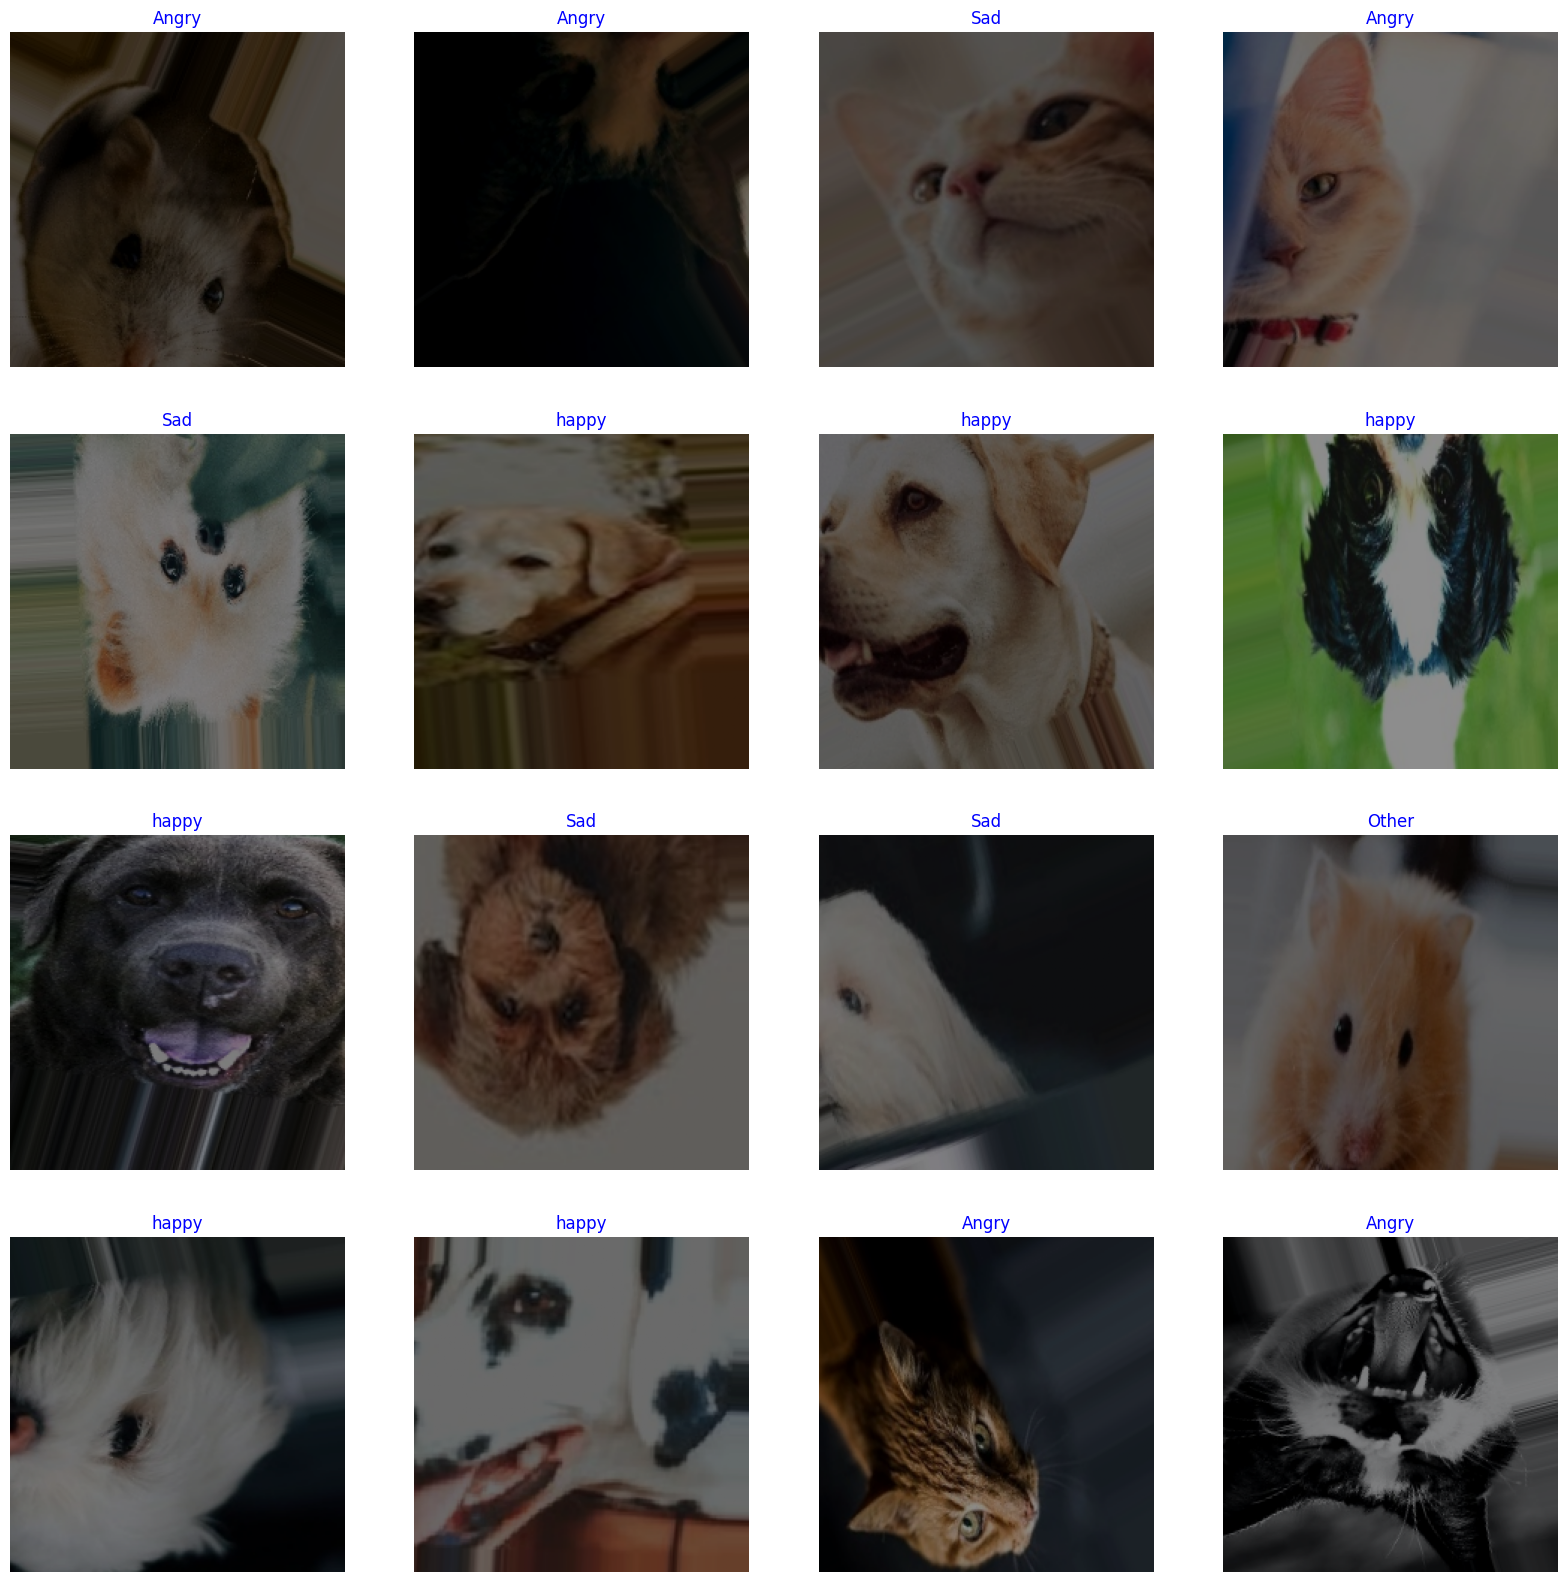

In [16]:
g_dict = train_gen.class_indices      
classes = list(g_dict.keys())     
images, labels = next(train_gen)  
plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
    
plt.show()

In [19]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, activation='relu'),
    Dense(128, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb5 (Functional)     │ ?                      │    28,513,527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,513,527 (108.77 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 28,513,527 (108.77 MB)

In [20]:
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=5, 
                               restore_best_weights=True,
                               mode='max',
                              )

def step_decay(epoch):
    
     initial_lrate = 0.1
     drop = 0.5
     epochs_drop = 10.0
     lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
     return lrate

lr_scheduler = LearningRateScheduler(step_decay)

In [22]:
batch_size = 15
epochs = 50

history = model.fit(x=train_gen,
                    epochs= epochs,
                    verbose= 1,
                    validation_data= valid_gen, 
                    validation_steps= None,
                    shuffle= False)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.3486 - loss: 4.0362 - val_accuracy: 0.3583 - val_loss: 3.8994
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.3368 - loss: 3.8369 - val_accuracy: 0.3750 - val_loss: 3.7011
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.3453 - loss: 3.6632 - val_accuracy: 0.4167 - val_loss: 3.5513
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - accuracy: 0.3482 - loss: 3.5318 - val_accuracy: 0.4250 - val_loss: 3.4086
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.3843 - loss: 3.3862 - val_accuracy: 0.3583 - val_loss: 3.3005
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.3449 - loss: 3.2587 - val_accuracy: 0.4083 - val_loss: 3.1517
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.3320 - loss: 3.1443 - val_accuracy: 0.3917 - val_loss: 3.0455
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.3156 - loss: 3.0333 - val_accuracy: 0.3500 - v

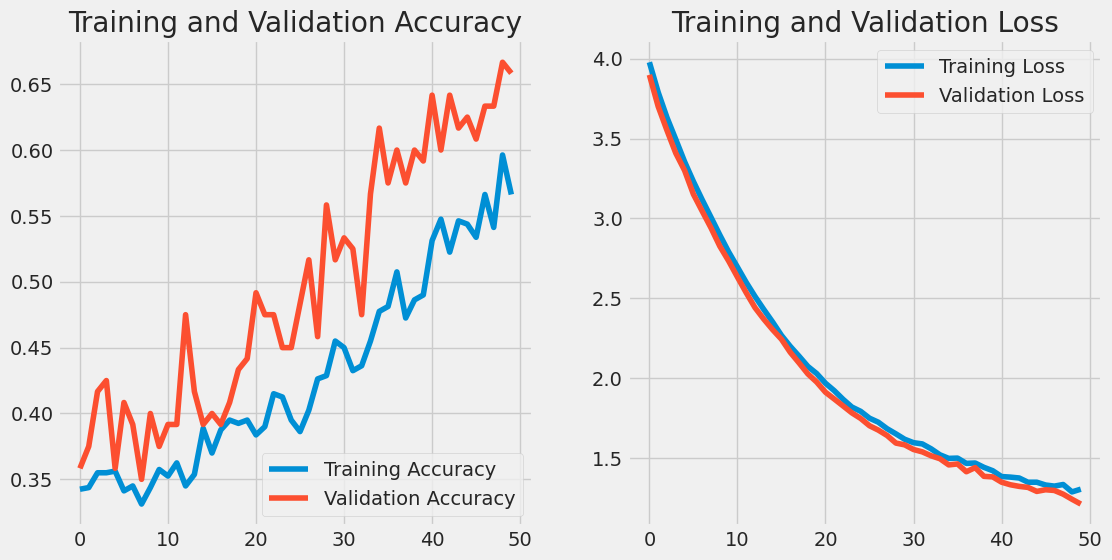

In [30]:
# Extracting history data
history_dict = history.history
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Setting up epochs range
epochs_range = range(len(accuracy))

# Plotting Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [31]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5625 - loss: 1.4173
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7500 - loss: 1.1221
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.5375 - loss: 1.7894
Train Loss:  1.4172863960266113
Train Accuracy:  0.5625
--------------------
Test Loss:  1.7893747091293335
Test Accuracy:  0.5375000238418579


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


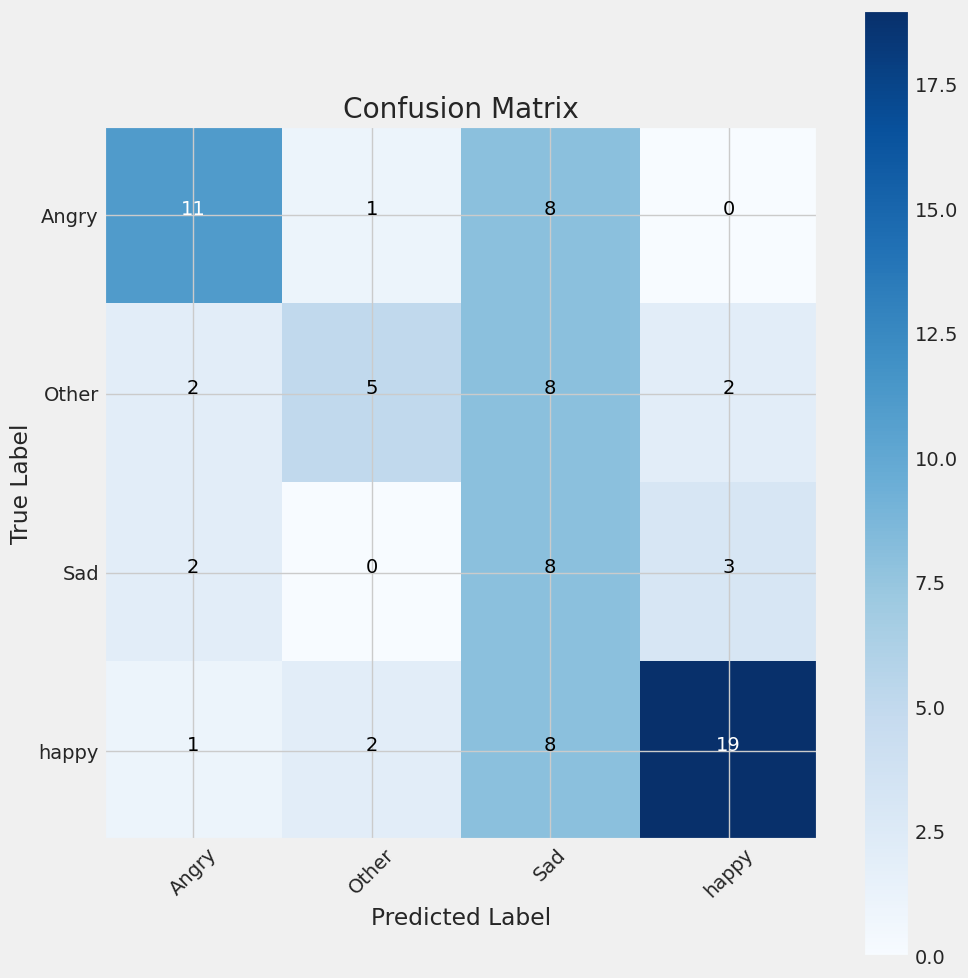

In [36]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Predict labels
y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [37]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       Angry       0.69      0.55      0.61        20
       Other       0.62      0.29      0.40        17
         Sad       0.25      0.62      0.36        13
       happy       0.79      0.63      0.70        30

    accuracy                           0.54        80
   macro avg       0.59      0.52      0.52        80
weighted avg       0.64      0.54      0.56        80



#  Predict the Inputs

In [38]:
model.save_weights('efficientNet.weights.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


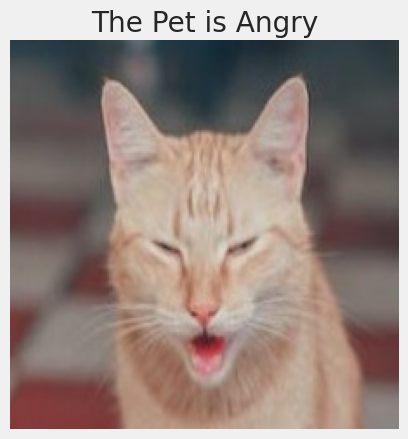

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


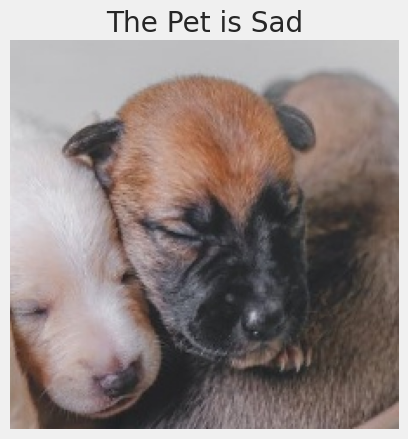

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


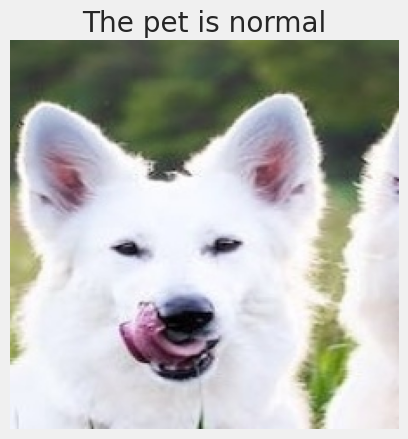

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


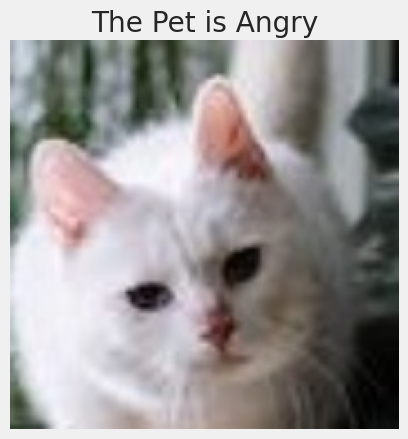

In [39]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_and_display(image_path, model):
    
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    
    class_indices = train_gen.class_indices
    class_labels = list(class_indices.keys())
    predicted_class_label = class_labels[predicted_class_index]
    
    plt.imshow(img)
    plt.axis('off')
    if predicted_class_label == 'Other':
        plt.title(f"The pet is normal")
    else:
        plt.title(f"The Pet is {predicted_class_label}")
    plt.show()

model.load_weights('/kaggle/working/efficientNet.weights.h5')

class_labels = ['Angry', 'Other', 'Sad', 'Happy']

image_path_to_test = '/kaggle/input/pets-facial-expression-dataset/Angry/02.jpg'
predict_and_display(image_path_to_test, model)

image_path_to_test = '/kaggle/input/pets-facial-expression-dataset/Sad/031.jpg'
predict_and_display(image_path_to_test, model)

image_path_to_test = '/kaggle/input/pets-facial-expression-dataset/happy/032.jpg'
predict_and_display(image_path_to_test, model)

image_path_to_test = '/kaggle/input/pets-facial-expression-dataset/Other/20.jpg'
predict_and_display(image_path_to_test, model)